# Notebook description

This notebook examines the rate-based adaptive LIF (raLIF) neuron. We're interested in the raLIF neuron because it's easier to analyze than the spiking adaptive (aLIF) neuron. More specifically, we can model the output firing rate dynamics of the raLIF neuron and match its output dynamics to the aLIF neuron spiking dynamics. For the aLIF neuron analysis, go to [this notebook](http://nbviewer.ipython.org/github/fragapanagos/notebooks/blob/master/neuron/adaptive_LIF_neuron.ipynb). Here, we specifically look to answer
 - What is the steady-state rate of a raLIF neuron?
 - What are the dynamics of the raLIF neuron's output?

# Summary of results

<div style="display:block; border: 1px solid black; padding: 15px;background-color: #EEEEFF;margin: 10px">
<p>The raLIF neuron does not have a unique steady-state output for a given input. The steady-state output depends on the initial conditions. The adaptive rate LIF neuron has no analytical solution for its steady state rates, but we can use numerical methods.</p>

<p>We can make the raLIF neuron match both the steady-state firing rate and firing rate dynamics of the spiking adaptive neuron by </p>

<ol>
    <li> scaling the input to the raLIF neuron and </li>
    <li> initializing the raLIF neuron to the open-loop rate given the scaled input </li>
</ol>

<p>The raLIF neuron dynamics are governed by

\begin{align}
\frac{\tau_f}{\tau_mx_t}\frac{df}{dt} &= \frac{u_f}{u_{net}(u_{net}-x_t)}f^2 - \frac{\alpha_f}{u_{net}(u_{net}-x_t)}f^3 \\
\end{align}

where

\begin{align}
\tau_f\frac{du_{net}}{dt} &= -u_{net}+u_{in}-\alpha_f f \\
\end{align}
</p>
</div>

# Background

The raLIF neuron's firing rate is described by

\begin{align}
f &= \frac{1}{t_{ref}-\tau_m\ln\left(1-\frac{x_t}{u_{net}}\right)} \\
\end{align}

where
 - $t_{ref}$ is the refractory period
 - $\tau_m$ is the soma membrane time constant
 - $x_t$ is the threshold (typically set to $1$)
 - $u_{net}$ is the net input ($u_{in}-u_f$) to the soma
 
As its name implies, the raLIF neuron does not output spikes. Instead, for a given $u_{net}$ it outputs a real-valued rate, $f$, which is the spike rate of an LIF neuron given $u_{net}$ as input. 

![rate-based adaptive LIF neuron](figures/rate_adaptive_LIF.png "rate-based adaptive LIF neuron")

For the nonadaptive LIF neuron, the net input to the soma is the same as the input to the neuron. That is, $u_{net}=u_{in}$. For the adaptive LIF neuron, there is also an adaptive negative feedback $u_f$ input so that

\begin{align}
u_{net} &= u_{in}-u_f \\
\end{align}

The adaptive feedback term has the dynamics of a first order low-pass filter (i.e. a simple synapse) so that

\begin{align}
\tau_f\dot{u}_f &= -u_f+\alpha_f f \\
\end{align}

Since $u_{net} = u_{in} - u_f$,

\begin{align}
\dot{u}_{net} &= -\dot{u}_f \\
\end{align}

if we assume $u_{in}$ is constant. Therefore,

\begin{align}
\tau_f\dot{u}_{net} &= u_f-\alpha_f f \\
 &= -u_{net}+u_{in}-\alpha_f f \\
\end{align}

# Simulation setup

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from IPython.html.widgets import interactive
from IPython.display import display

from utils.adaptive_LIF_rate_neuron_notebook import (
    phase_u_f, u_in_traj, add_traj, u_in_gain, rate_v_spiking, f_traj, plotcheck_J, contraction_analysis)
from utils.neuron import th_lif_fi, th_ralif_dfdt, num_ralif_fi, run_ralifsoma
from utils.plot import make_blue_cmap, make_red_cmap, make_color_cycle

tau_m, tref, xt = .01, .005, 1.
af, tau_f = .02, .005
dt = 1e-3

:0: FutureWarning: IPython widgets are experimental and may change in the future.


# Analysis

## Steady state

At steady state, $\dot{u}_{net}=0$, so

\begin{align}
0 &= -u_{net}+u_{in}-\alpha_f f \\
u_{net} &= u_{in} - \alpha_ff \\
\end{align}

The steady state firing rate would then be

\begin{align}
f &= \frac{1}{t_{ref}-\tau_m\ln\left(1-\frac{x_t}{u_{in}-\alpha_f f}\right)} \\
\end{align}

There isn't an analytical solution for $f$ for this equation. However we can find the firing rate numerically using the bisection method as in the [spiking adaptive LIF notebook mean feedback approximation](http://nbviewer.ipython.org/github/fragapanagos/notebooks/blob/master/neuron/adaptive_LIF_neuron.ipynb#Mean-feedback-approximation---numerical-solution) (without compensating for the refractory period decay of the feedback in $\alpha_f$). Next, we will see that this solution isn't unique when analyzing the dynamics.

## Dynamics

We would like to know $\frac{df}{dt}$. Our approach is to find $\frac{\partial f}{\partial u_{net}}$ and $\frac{\partial u_{net}}{\partial t}$ and then apply the chain rule, which states that

$$\frac{df}{dt}=\frac{\partial f}{\partial u_{net}}\frac{\partial u_{net}}{\partial t}$$

We already have $\frac{\partial u_{net}}{\partial t}$ from above. For $\frac{df}{dt}$,

\begin{align}
f &= \frac{1}{t_{ref}-\tau_m\ln\left(1-\frac{x_t}{u_{net}}\right)} \\
\frac{\partial f}{\partial u_{net}} &= 
    \frac{-1}{\left(t_{ref}-\tau_m\ln\left(1-\frac{x_t}{u_{net}}\right)\right)^2}
    \left(\frac{-\tau_m}{1-\frac{x_t}{u_{net}}}\right)
    \left(\frac{x_t}{{u_{net}}^2}\right) \\
 &= f^2\frac{\tau_m}{\frac{u_{net}-x_t}{u_{net}}}\frac{x_t}{{u_{net}}^2} \\
 &= f^2\frac{\tau_mx_t}{u_{net}(u_{net}-x_t)} \\
\end{align}

Using $\frac{df}{dt}=\frac{\partial f}{\partial u_{net}}\frac{\partial u_{net}}{\partial t}$,

\begin{align}
\frac{df}{dt} &= 
    f^2\frac{\tau_mx_t}{u_{net}(u_{net}-x_t)}
    \frac{1}{\tau_f}(u_f-\alpha_f f) \\
\frac{\tau_f}{\tau_mx_t}\frac{df}{dt} &= \frac{1}{u_{net}(u_{net}-x_t)}f^2(u_f-\alpha_f f) \\
 &= \frac{u_f}{u_{net}(u_{net}-x_t)}f^2 - \frac{\alpha_f}{u_{net}(u_{net}-x_t)}f^3 \\
\end{align}

<div style="display:block; border: 1px solid black; padding: 15px;background-color: #EEEEFF;margin: 10px">
To summarize the dynamics,

\begin{align}
\tau_f\frac{du_{net}}{dt} &= -u_{net}+u_{in}-\alpha_f f \\
\end{align}

and

\begin{align}
\frac{\tau_f}{\tau_mx_t}\frac{df}{dt} &= \frac{u_f}{u_{net}(u_{net}-x_t)}f^2 - \frac{\alpha_f}{u_{net}(u_{net}-x_t)}f^3 \\
 \end{align}
</div>

At this point, we can see why the steady state value firing rate is not unique across $u_{net}$ and $f$. First, considering $\frac{du_{net}}{dt}=0$,

\begin{align}
0 &= u_f - \alpha_ff \\
u_f &= \alpha_ff \\
\end{align}

Now considering $\frac{df}{dt}=0$, 

\begin{align}
0 &= u_ff^2 - \alpha_ff^3 \\
 &= f^2(u_f - \alpha_ff) \\
\end{align}

which has solutions at 

\begin{align}
f&=0, & f&=\frac{u_f}{\alpha_f} \\
\end{align}

which is reassuringly consistent with our solution for $\frac{du_{net}}{dt}=0$. The solution also says that any pair $(u_{net}, f)$ satisfying the linear relation $f=\frac{u_f}{\alpha_f}$ will be a steady-state.

Here's a phase plot of $u_{net}$ vs $f$ that shows how the linear relation between steady-state $u_{net}$ and $f$. The [Appendix](#Phase-plot-verification) verifies that the phase plot matches the dynamics of the neuron. If you run the cell, you can interact with the plot.

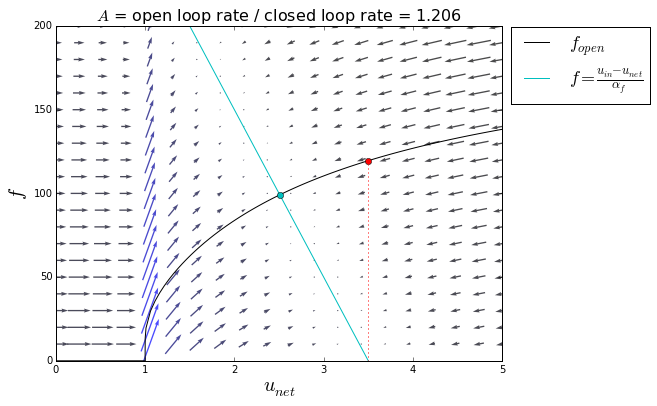

In [3]:
def interactive_phase_u_f(u_in=3.5, logaf=-2.):
    tau_m, tref, xt = .01, .005, 1.
    tau_f = .005
    dt = 1e-3
    
    af = 10**logaf
    fig, ax = phase_u_f(tau_m, tref, xt, af, tau_f, u_in=u_in)
    f_open = th_lif_fi(u_in, tau_m, tref, xt)
    ax.plot(u_in, f_open, 'ro')
    ax.plot([u_in, u_in], [0, f_open], 'r:')
    f_closed = num_ralif_fi(u_in, tau_m, tref, xt, af)
    gain = f_open/f_closed
    ax.set_title(r'$A$ = open loop rate / closed loop rate = %.3f' % gain, fontsize=16)
    
display(interactive(interactive_phase_u_f, u_in=(1.01, 10.), logaf=(-6., 1.)))

$f_{open}$ is the open-loop (without adaptive feedback) firing rate of an LIF neuron. If we initialize $u_{net}$ to $u_{in}$ and $f$ to the open-loop firing rate given $u_{in}$, we will observe the similar dynamics as the spiking adaptive neuron. In fact, if we initialize anywhere on $f_{open}$, we should settle on the same steady-state firing rate. However, if we initialize elsewhere in the phase plot, we see that the steady state value could fall anywhere on the $f=\frac{u_{in}-u_{net}}{\alpha_f}$ line.

With $u_{net}$ and $f$ initialized to the open-loop conditions, we see that feedback causes the initial firing rate to decrease and define the gain $A = \frac{f_{open}}{f_{closed}}$ as the relative gain between the open and closed-loop (with adaptive feedback) rates.

# Rate vs spiking implementation

We now move to comparing the raLIF neuron's dynamics with the aLIF neuron's dynamics. Recall that the raLIF LIF neuron is really only useful because we can analyze its dynamics.

Here, we drive an aLIF, raLIF, and LIF neuron with constant inputs, send their outputs to an observer synapse, and observe the output of the observer synapse. First, we'll use a fast synaptic time constant (to estimate the instantaneous spiking rate). The inputs are set so that the steady state output spike rates match.

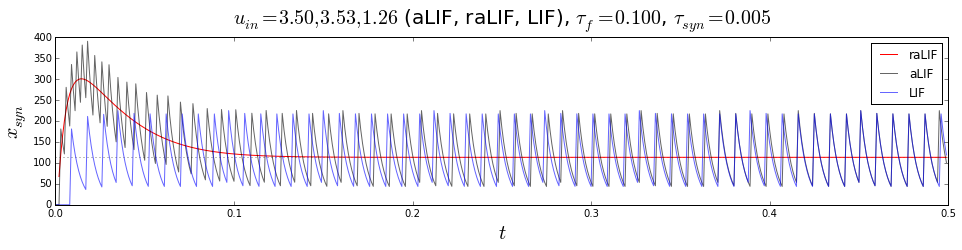

In [4]:
tau_m = .005
tref = .001
xt = 1.
af = .02
tau_f = .1

dt = 1e-3
T = 5*tau_f

rate_v_spiking(3.5, tau_m, tref, xt, af, tau_f, tau_f/20., dt, T);

See how the observed dynamics of the aLIF neuron output match the observed dynamics of the raLIF neuron output. 

Now, matching the feedback time constant to the observer synapse' time constant, we see that the raLIF and aLIF neurons always drives the observer synapse faster than the LIF neuron. Here is an interactive plot.

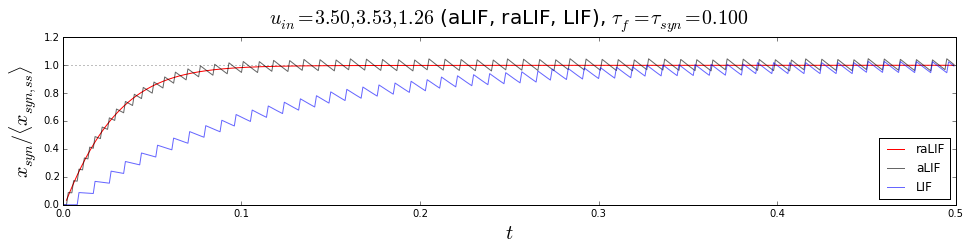

In [5]:
def interactive_rate_v_spiking(alif_u_in=3.5):
    rate_v_spiking(alif_u_in, tau_m, tref, xt, af, tau_f, tau_f, dt, T, normalize=True)
display(interactive(interactive_rate_v_spiking, alif_u_in=(xt*1.5, 10.)))

Here are a few static plots with varying inputs.

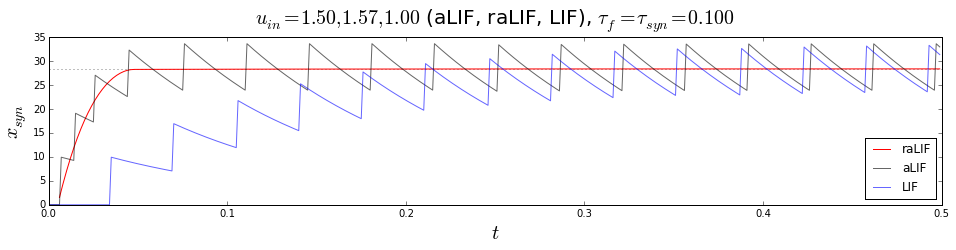

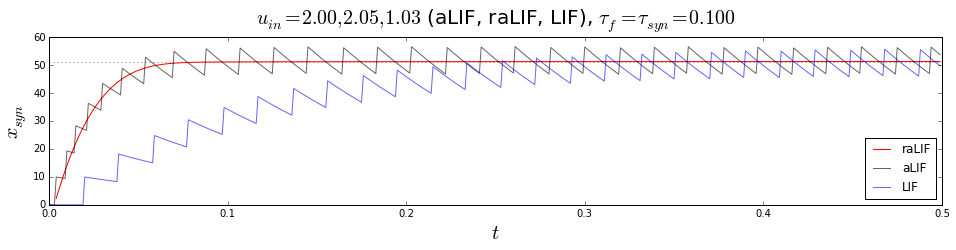

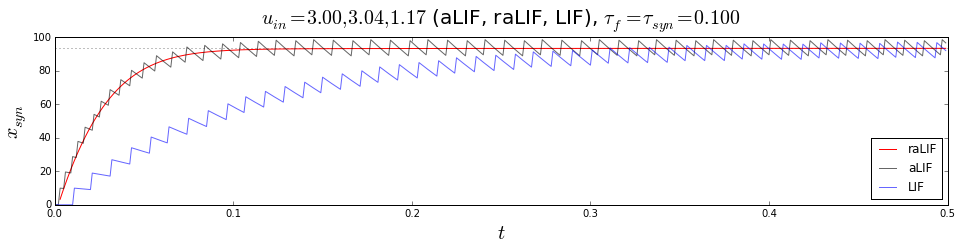

In [6]:
u_ins = [1.5, 2.0, 3.0,]

for u_in in u_ins:
    rate_v_spiking(u_in, tau_m, tref, xt, af, tau_f, tau_f, dt, T)

Note how the speedup actually decreases with as input increases. This is easier to appreciate when using the interactive plot, but on the static plots, see how the black line gets closer to the blue trace with higher inputs. 

One benefit of the raLIF neuron is that we can access the instantaneous rate and don't have to use an observer synapse. Here is an interactive plot of the instantaneous rate over time.

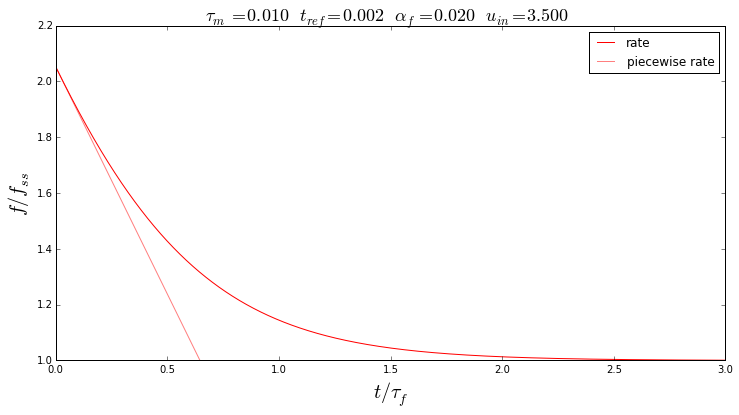

In [7]:
def interactive_f_traj(u_in=3.5, tau_m=.01, tref=.002, af=.02, log10dt=-4, normalize_y=True):
    dt = 10**log10dt
    f_traj(u_in, tau_m, tref, xt, af, tau_f, dt, normalize_y=normalize_y)

display(interactive(
        interactive_f_traj, u_in=(1.01*xt, 5.), tau_m=(.001, .05, .001), tref=(0., .01, .001),
        af=(.001, .1, .001), log10dt=(-5, -3)))

The slightly transparent line shows a piecewise approximation of the instantaneous rate. Below is the instantaneous rate over time for varying $u_{in}$. 

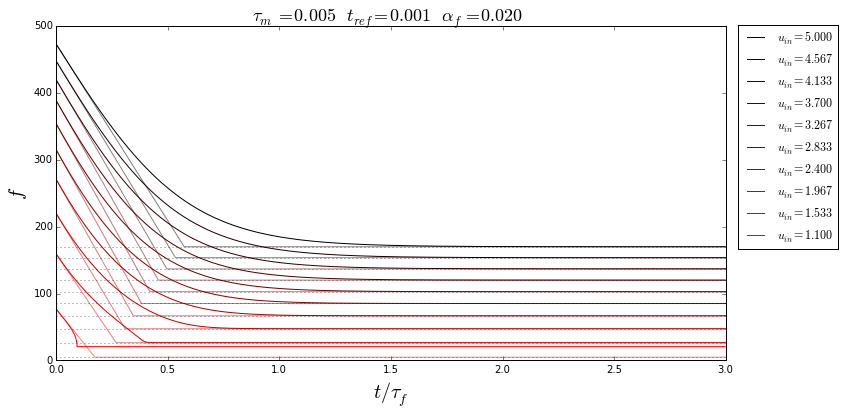

In [8]:
u_ins = np.linspace(1.1, 5, 10)
f_traj(u_ins, tau_m, tref, xt, af, tau_f, dt=1e-4);

Note how the piecewise approximation rate undershoots the instantaneous rate for a wide range of inputs. Therefore we can use the approximation as a pessimistic estimate of adaptive neuron output. It is pessimistic because the synaptic response to the approximation will be slower than the synaptic response to the actual output.

However, the piecewise approximation overshoots the instantaneous rate for inputs near threshold. This isn't so problematic for using adaptation in NEF networks because the slowest neurons will limit the speed of the Ensemble. As seen with the observer synapse, the slowest observer synapse responses come from neurons with the highest input. Therefore, the piecewise approximation gives us a pessimistic handle on the worst case synaptic response speed.

Here is the rate filtered by a synapse. This plot is interactive.

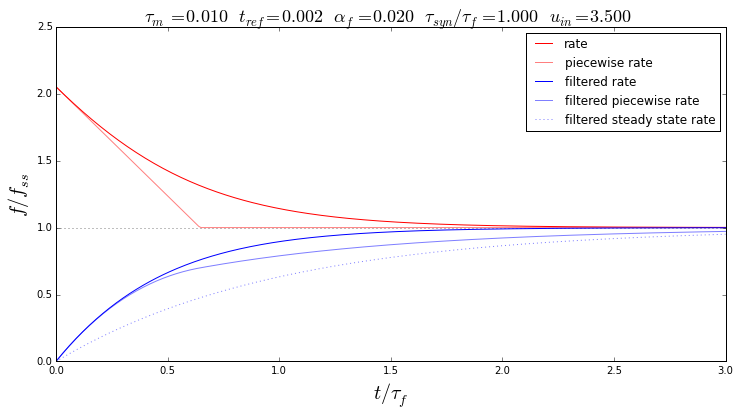

In [9]:
def interactive_f_traj(u_in=3.5, tau_m=.01, tref=.002, af=.02, tau_syn=tau_f, log10dt=-3, normalize_y=True):
    dt = 10**log10dt
    f_traj(u_in, tau_m, tref, xt, af, tau_f, dt, tau_syn=tau_syn, normalize_y=normalize_y)

display(interactive(
        interactive_f_traj, u_in=(1.3*xt, 5.), tau_m=(.001, .05, .001), tref=(0., .01, .001),
        af=(.001, .1, .001), tau_syn=(.01, .2, .001), log10dt=(-5, -3)))

Note how the filtered piecewise rate is slightly slower than that filtered rate. Varying $u_{in}$, you can see how the synaptic speed decreases with increasing $u_{in}$.

# Open loop vs closed loop gain vs synaptic speedup

To explain the dependence of the speedup on the input, consider the gain between the open loop firing rate and the closed loop firing rate. Here is an interactive plot.

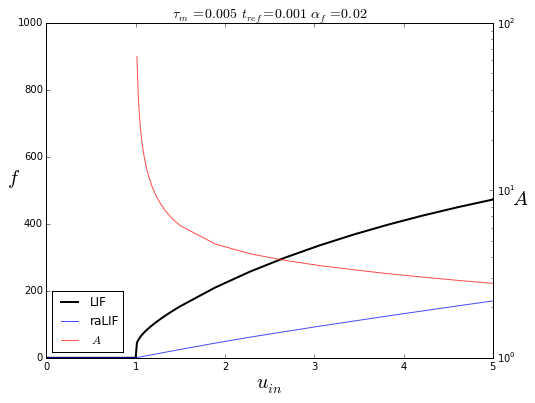

In [10]:
# plot gain vs u_in

def interact_u_in_gain(tau_m_ms=5., tref_ms=1., af_1000=20):
    tau_m = tau_m_ms / 1000.
    tref = tref_ms / 1000.
    af = af_1000/1000.
    u_in_gain(tau_m, tref, xt, af)

display(interactive(interact_u_in_gain, tau_m_ms=(1, 100), tref_ms=(0., 10), af_1000=(1., 1000.)))

See how the gain decreases with increasing input.

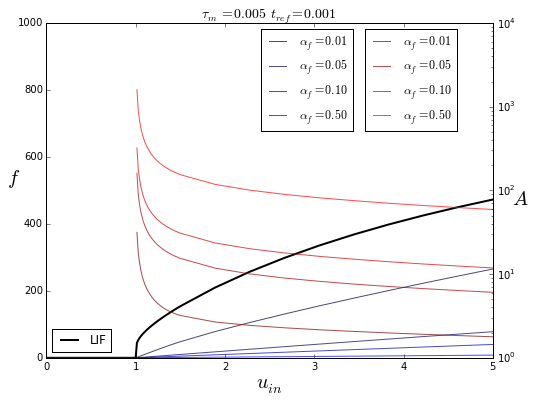

In [11]:
# plot gain vs u_in
afs = [.01, .05, .1, .5]
u_in_gain(tau_m, tref, xt, afs)

# Contraction analysis 

This part has been taken from [Lohmiller and Slotine 1996]. For system

$$\dot{\mathbf{x}} = \mathbf{f}(\mathbf{x},t)$$

Consider a virtual (aka differential) displacement $\delta \mathbf{x}$ from a trajectory satisfying the system equation. This virtual displacement is an infintesimal displacement at fixed time. 

$$\delta \dot{\mathbf{x}} = \frac{\partial \mathbf{f}}{\partial \mathbf{x}}(\mathbf{x},t)\delta \mathbf{x}$$

where $\frac{\partial \mathbf{f}}{\partial \mathbf{x}}$ defines a Jacobian.

The squared distance between two trajectories is 

$$\delta \mathbf{x}^T\delta \mathbf{x}$$

so 

\begin{align}
\frac{d}{dt}(\delta \mathbf{x}^T\delta \mathbf{x}) &= 2\delta \mathbf{x}^T\delta \dot{\mathbf{x}} \\
 &= 2\delta \mathbf{x}^T\frac{\partial \mathbf{f}}{\partial \mathbf{x}}(\mathbf{x},t)\delta \mathbf{x} \\
\end{align}

which we recognize as a quadratic form with respect to the Jacobian $\frac{\partial \mathbf{f}}{\partial \mathbf{x}}$. Only the symmetric portion of the Jacobian 
$\frac{1}{2}\left(\frac{\partial \mathbf{f}}{\partial \mathbf{x}} + \frac{\partial \mathbf{f}}{\partial \mathbf{x}}^T\right)$
affects the quadratic form, so letting $\lambda_{max}(\mathbf{x}, t)$ be the largest eigenvalue of the symmetric part of the Jacobian, we have

$$\frac{d}{dt}(\delta\mathbf{x}^T\delta\mathbf{x}) \le 2 \lambda_{max}\delta\mathbf{x}^T\delta\mathbf{x}$$

so

$$\|\delta\mathbf{x}\| \le \|\delta\mathbf{x}_0\|e^{\int_0^t\lambda_{max}(\mathbf{x},t)dt}$$

If $\lambda_{max}<0$ is uniformly strictly negative ($\frac{\partial\mathbf{f}}{\partial\mathbf{x}}$ is negative definite) then we are guaranteed that $\delta\mathbf{x}$ shrinks exponentially to $\mathbf{0}$. The region where $\frac{\partial\mathbf{f}}{\partial\mathbf{x}}$ is negative definite is called a contracting region.

# Applying contraction analysis to the raLIF neuron dynamics

Here we apply Slotine's contraction analysis to the rate-based adaptive LIF neuron. Our system has variables $u_{net}$ and $f$.

\begin{align}
\frac{\tau_f}{\tau_mx_t}\frac{df}{dt} &= 
    \frac{u_{in}-u_{net}}{u_{net}(u_{net}-x_t)}f^2 - \frac{\alpha_f}{u_{net}(u_{net}-x_t)}f^3 \\
\end{align}

and

\begin{align}
\tau_f\frac{du_{net}}{dt} &= -u_{net}+u_{in}-\alpha_f f \\
\end{align}

We find the Jacobian and examine its eigenvalues.

Rearranging our system equations,

\begin{align}
\frac{df}{dt} &= \frac{\tau_mx_t}{\tau_f}\frac{f^2(u_{in}-\alpha_ff-u_{net})}{u_{net}(-x_t+u_{net})} \\
\frac{du_{net}}{dt} &= \frac{1}{\tau_f}(u_{in}-\alpha_ff-u_{net}) \\
\end{align}

The system is in the form

$$\dot{\mathbf{x}} = \mathbf{f}(\mathbf{x},t)$$

where $\mathbf{x} =
\begin{bmatrix}
f \\ u_{net}
\end{bmatrix}$ and


$$\mathbf{f} =
\begin{bmatrix}
\frac{\tau_mx_t}{\tau_f}\frac{f^2(u_{in}-\alpha_ff-u_{net})}{u_{net}(-x_t+u_{net})} \\
\frac{1}{\tau_f}(u_{in}-\alpha_ff-u_{net}) \\
\end{bmatrix}
$$

The Jacobian is then

\begin{align}
J &= \frac{\partial \mathbf{f}}{\partial \mathbf{x}} \\
  &= \begin{bmatrix}
    \frac{\partial f_1}{\partial x_1} & \frac{\partial f_1}{\partial x_2} \\
    \frac{\partial f_2}{\partial x_1} & \frac{\partial f_2}{\partial x_2} \\
    \end{bmatrix} \\ \\
  &=
    \begin{bmatrix}
    \frac{\tau_mx_t}{\tau_f}\frac{f(2u_{in}-3\alpha_ff-2u_{net})}{u_{net}(-x_t+u_{net})}  & 
    \frac{\tau_mx_t}{\tau_f}\frac{f^2\left(u_{in}(x_t-2u_{net})+u_{net}^2-\alpha_ff(x_t-2u_{net})\right)}
          {u_{net}^2(-x_t+u_{net})^2} \\
    -\frac{\alpha}{\tau_f} & -\frac{1}{\tau_f}
    \end{bmatrix} \\ \\
\end{align}

First we'll check the correctness of the Jabobian by comparing the theoretical partial derivatives to the numerically estimated partial derivatives. 

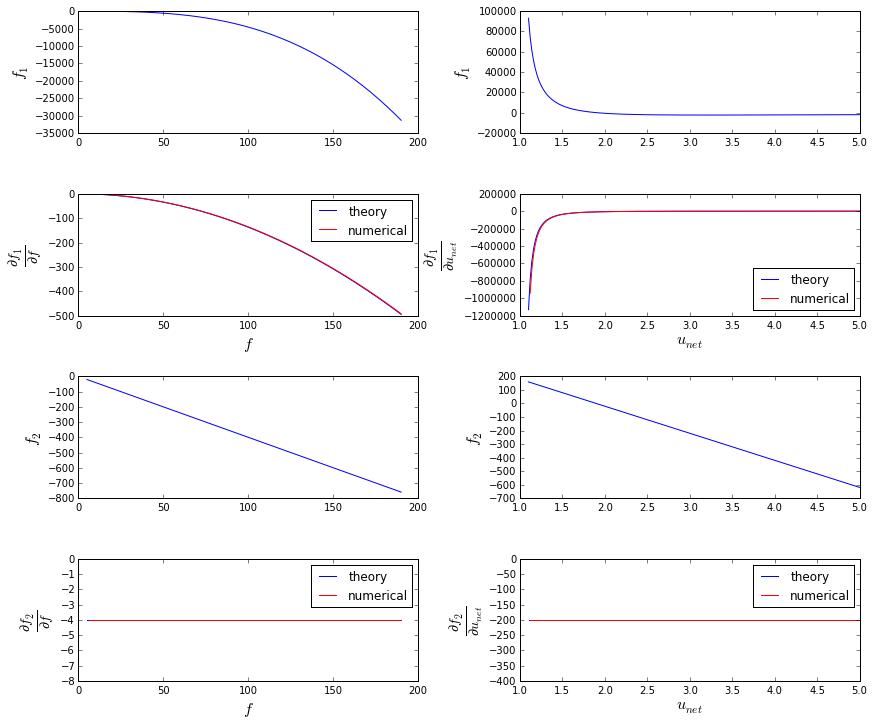

In [12]:
# check that Jacobian make sense
tau_m, tref, xt = .01, .005, 1.
af, tau_f = .02, .005
dt = 1e-4
plotcheck_J(tau_m, tref, xt, af, tau_f, dt, u_in=3.5)

The above plots check the four entries of the Jacobian. For each Jacobian element, I plot its corresponding element in $\mathbf{f}$ as a function of the partial derivative variable in the top plot and the Jacobian element as a function of the partial derivative variable in the bottom plot. The numerical and theoretical partial derivatives seem to match. 

Now we examine the distance squared $\delta\mathbf{x}^T\delta\mathbf{x}$. Recall that $\delta\mathbf{x}$ is a vector describing the difference between two trajectories. We would like to describe how fast the open-loop firing rate converges to the steady-sate firing rate. Therefore, we define our trajectories with

$$\delta\mathbf{x}(t)=
\begin{bmatrix}
f_{ss}-f(t) \\ u_{net, ss}-u_{net}(t)
\end{bmatrix}$$

where $f_{ss}$ and $u_{net,ss}$ are the steady-state firing rate and net input, respectively, so $\delta\mathbf{x}$ describes the deviation of the system from steady-state. First we run a simulation and confirm that the system reaches steady state.

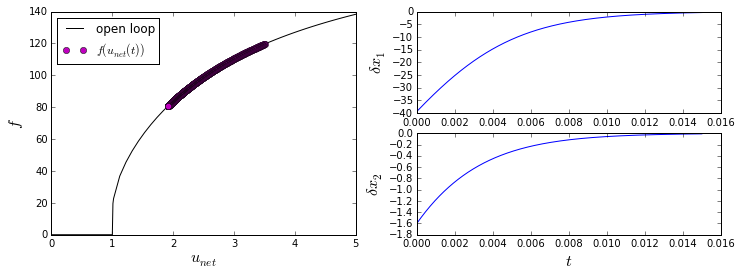

In [13]:
from utils.adaptive_LIF_rate_neuron_notebook import plot_traj, plot_contraction, plot_components
tau_m, tref, xt = .01, .005, 1.
af, tau_f = .02, .005
dt = 1e-5
u_in = 3.5
con_dat = contraction_analysis(u_in, tau_m, tref, xt, af, tau_f, dt)
plot_traj(con_dat['t'], con_dat['u_net'], con_dat['f'], con_dat['delta'], tau_m, tref, xt)

The above plots show the system statespace on the left and the components of $\delta\mathbf{x}$ over time on the right. The system is initalized with $u_{net}(0)=u_{in}=3.5$ and $f$ set to the open-loop rate given $u_{in}$. We see that $\delta\mathbf{x}\rightarrow\mathbf{0}$, confirming that the system reaches the predicted steady state.

Next, we look at $\delta\mathbf{x}^T\delta\mathbf{x}$ and $\frac{\partial\mathbf{f}}{\partial\mathbf{x}}$ over time.

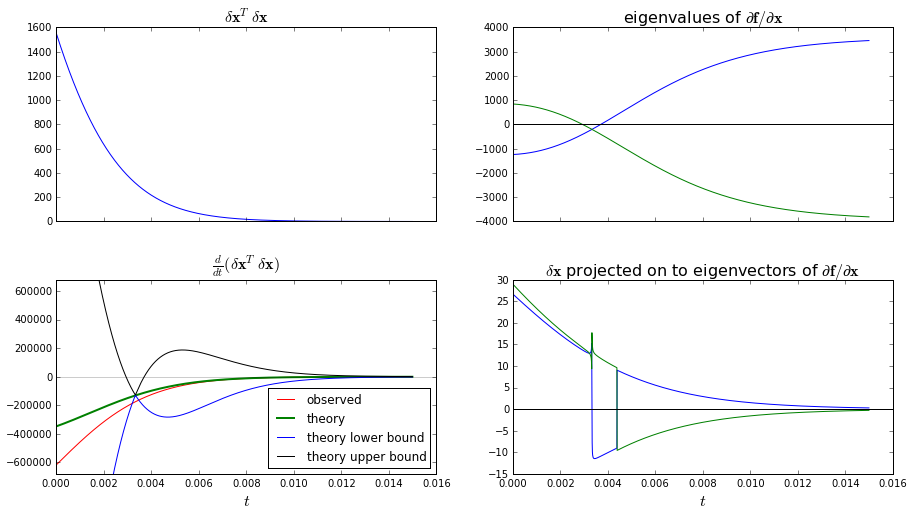

In [14]:
plot_contraction(con_dat['t'], con_dat['dist_sq'], con_dat['ddist_sq_num'], con_dat['ddist_sq'],
                 con_dat['ddist_sq_lb'], con_dat['ddist_sq_ub'], con_dat['eigenvals'], con_dat['projections'])

We see that $\delta\mathbf{x}^T\delta\mathbf{x}\rightarrow0$, but the observed $\frac{d}{dt}(\delta\mathbf{x}^T\delta\mathbf{x})$ does not match the theoretical prediction that 

\begin{align}
\frac{d}{dt}(\delta \mathbf{x}^T\delta \mathbf{x}) &= 2\delta \mathbf{x}^T\frac{\partial \mathbf{f}}{\partial \mathbf{x}}(\mathbf{x},t)\delta \mathbf{x} \\
\end{align}

I'm still not sure exactly why the observed derivative doesn't match the theory...
Since the Jacobian checks out numerically, perhaps this indicates something wrong with the simulation...? [TODO] Dig further into why the simulation doesn't match the theory.

However, more problematic is that the eigenvalues are not always negative, indicating that this is not a contracting system. Perhaps I can find a metric in which the system is contracting...[TODO] Find a way to pick the metric.

We can further examine the system by decomposing the quadratic form into the components associated with each eigenvalue.

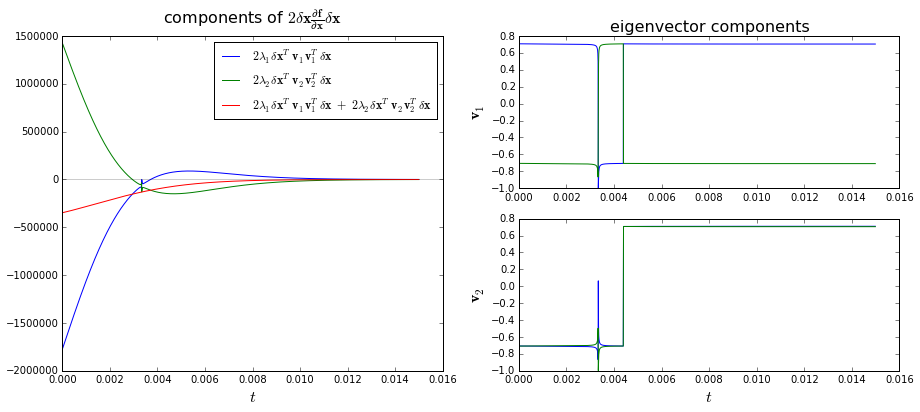

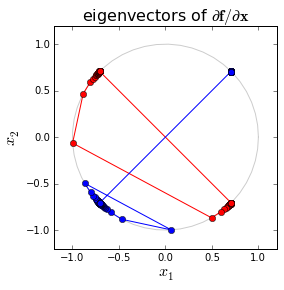

In [15]:
plot_components(con_dat['t'], con_dat['eigenvals'], con_dat['projections'], con_dat['evects'])

We see that $\delta\mathbf{x}$ has components along both of the eigenvectors, but the sum of the components along each eigenvector is always negative.

# Appendix

# Phase plot verification

Do simulated trajectories line up with the phase plot? Let's run the system with a few different initial conditions.

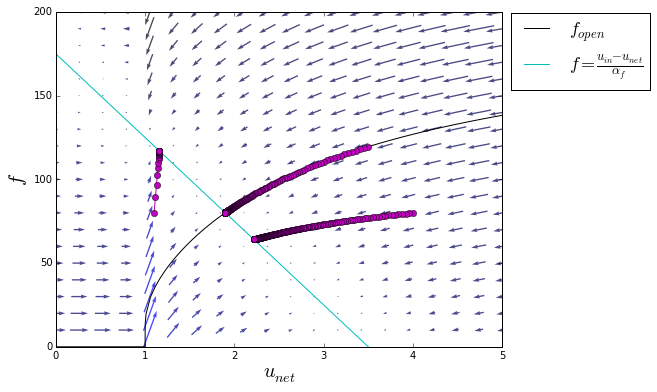

In [16]:
u_in = 3.5
dt = 1e-4
fig, ax = phase_u_f(tau_m, tref, xt, af, tau_f, dt=dt, u_in=u_in)
add_traj(ax, u_in, tau_m, tref, xt, af, tau_f, dt=dt)
add_traj(ax, u_in, tau_m, tref, xt, af, tau_f, dt=dt, u0=1.1, f0=80.)
add_traj(ax, u_in, tau_m, tref, xt, af, tau_f, dt=dt, u0=4.0, f0=80.)

The trajectories all find some point on the steady steate line. We see that each trajectory's steady state value depends on its initial condition. The steady state values that are consistent with ths spiking adaptive neuron are attained when initialized along the open loop tuning curve.

# Simulator verification

Here we verify that the change in firing rate over time of the simulation matches the theoretical change in firing rate over time.

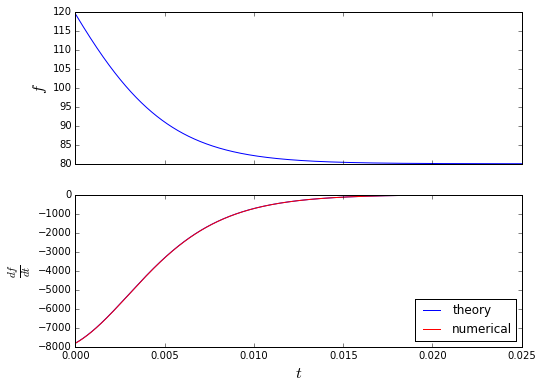

In [17]:
tau_m, tref, xt = .01, .005, 1.
af, tau_f = .02, .005
dt = 1e-5
u_in = 3.5

f_ss = num_ralif_fi(u_in, tau_m, tref, xt, af)
f0 = th_lif_fi(u_in, tau_m, tref, xt)

T = 5. * tau_f
n = int(np.ceil(T/dt))
u_in_arr = u_in * np.ones(n)
f, u_net = run_ralifsoma(dt, u_in_arr, tau_m, tref, xt, af, tau_f, f0=f0, u0=u_in, ret_u=True)
t = dt * np.arange(n)

dfdt = th_ralif_dfdt(u_net, u_in, f, tau_m, tref, xt, af, tau_f)
dfdt_num = np.diff(f)/dt

fig, axs = plt.subplots(nrows=2, figsize=(8,6), sharex=True)
axs[0].plot(t, f)
axs[0].axhline(f_ss, c='k')
axs[1].plot(t, dfdt, 'b', label='theory')
axs[1].plot(t[1:], dfdt_num, 'r', label='numerical')
axs[1].legend(loc='lower right')
axs[0].set_ylabel(r'$f$', fontsize=16)
axs[1].set_xlabel(r'$t$', fontsize=16)
axs[1].set_ylabel(r'$\frac{df}{dt}$', fontsize=16)

The numerical and theoretical $df/dt$ align well.